# Creating an option pricer using a binomial tree

In [57]:
import numpy as np
import pandas as pd
import typing as tp
import math
import yfinance as yf
from datetime import datetime, timedelta

In [58]:
intf = tp.Union[int, float]

class Option_bintree:

    def __init__(self, kind: str, K: intf,
                 stock: tp.Union[pd.Series, pd.DataFrame], r_f: intf, steps: int,
                 T: intf) -> None:
        self.kind = kind.title()
        self.K = K
        self.stock = stock.asfreq('B')
        self.r_f = r_f
        self.T = T
        self.steps = steps
        self.dt = self.T/self.steps
    
    def find_states(self) -> tuple:
        stock = self.stock
        sigma = stock.pct_change(fill_method=None).std() if type(stock) == pd.Series else stock.iloc[:, 0].pct_change(fill_method=None).std()
        self.up = up = np.exp(sigma * np.sqrt(self.dt))
        self.down = down = np.exp(-sigma * np.sqrt(self.dt))
        return up, down

    def risk_neutral_prob(self) -> float:
        if hasattr(self, 'up') and hasattr(self, 'down'):
            pass
        else:
            self.find_states()
        self.q = q = (np.exp(self.r_f*self.dt) - self.down)/(self.up - self.down)
        return q

    def pricing(self, steps: tp.Optional[int] = None) -> float:
        if hasattr(self, 'q'):
            pass
        else:
            self.risk_neutral_prob()
        self.steps = steps if steps else self.steps

        # Set the latest stock price as the beginning price of the tree
        S_0 = self.stock.iloc[-1] if type(self.stock) == pd.Series else self.stock.iloc[-1, 0]

        # Initialize the stock tree
        self.stock_tree = stock_tree = np.zeros((self.steps, self.steps))
        for i in range(0, self.steps):
            for j in range(i, self.steps):
                stock_tree[i, j] = S_0 * self.up**(j-i) * self.down**(i)

        if self.kind == 'Call':

            # Initialize the call tree
            self.tree = tree = np.zeros((self.steps, self.steps))

            # Fill the last column of the call tree
            tree[:, -1] = np.maximum(stock_tree[:, -1] - self.K, 0)

        elif self.kind == 'Put':

            # Initialize the put tree
            tree = np.zeros((self.steps, self.steps))

            # Fill the last column of the put tree
            tree[:, -1] = np.maximum(self.K - stock_tree[:, -1], 0)

        # Fill the rest of the tree
        for j in range(self.steps-2, -1, -1):
            for i in range(0, j+1):
                tree[i, j] = np.exp(-self.r_f*self.dt) * (self.q*tree[i, j+1] + (1-self.q)*tree[i+1, j+1])
        
        price = tree[0, 0]
        return price






[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994
2023-12-28,193.580002
2023-12-29,192.529999


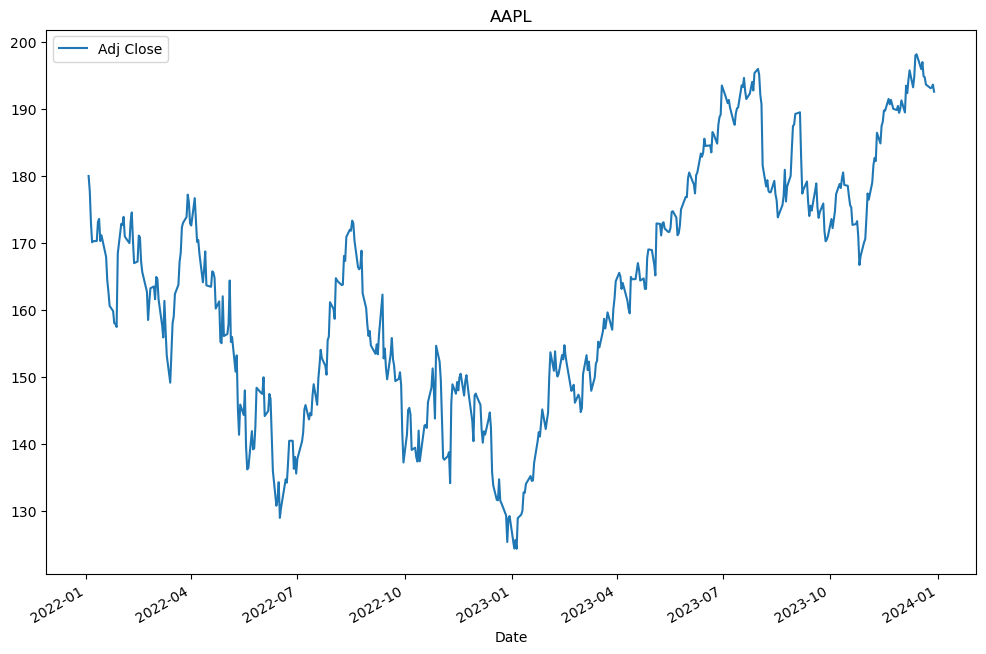

In [59]:

ticker = 'AAPL'
data = yf.download(ticker, start='2022-01-01', end=datetime.today()-timedelta(days=1))
data = data[['Adj Close']]
#show output
data.plot(figsize=(12, 8), title=ticker)
data.tail()


In [60]:
data.tail(1)

,Adj Close
Date,
2023-12-29,192.529999


In [61]:
#now price option
r_f = 0.05
K = 190
T = 1
steps = 2
option = Option_bintree('call', K, data, r_f, steps, T)

In [62]:
option.find_states()

(1.0130701000048599, 0.987098523582132)

In [63]:
option.risk_neutral_prob()

1.4714777539977635

In [64]:
option.pricing()

7.2211154939136515